In [1]:
import random
from joblib import dump, load


import numpy as np
import numpy.ma as ma  

import pandas as pd
import os
os.environ["CUDA_VISIBLE_DEVICES"] = ""

from scipy.stats import mannwhitneyu

from amp.utils.generate_peptides import translate_peptide
from amp.utils import phys_chem_propterties as phys
from amp.inference import HydrAMPGenerator
from amp.data_utils.sequence import pad, to_one_hot

import modlamp.descriptors
import modlamp.analysis
import modlamp.sequences


# PLOTTING 

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

# sns.set_style(
#     'whitegrid', 
#     {
#         'grid.color': '.95',
#         'axes.spines.right': False,
#         'axes.spines.top': False,
#     }
# )

params = {
    'axes.labelsize': 14,
    'axes.titlesize':14,
    'font.size': 14, 
    'legend.fontsize': 14,
    'xtick.labelsize': 14, 
    'ytick.labelsize': 14,
}

plt.rcParams.update(params)

Using TensorFlow backend.


In [2]:
models = [
    'Prototype',
    'PepZOO',
    'HydrAMP',
    'PepCVAE',
    'Basic',
]

palette_models = {  
    'Prototype': '#AF55FF',
    'PepZOO': '#B80018',
    'HydrAMP': '#D91115',       
    'PepCVAE': '#1d3557',
    'Basic': '#B4C5E4',
}


TEMPS = {
    'Prototype': [1],
    'PepZOO': [1],
    'HydrAMP': [5],
    'PepCVAE': [1],
    'Basic': [1],
}

In [3]:
boxprops = dict(linewidth=0.0, color='k')
flierprops = dict(linewidth=0.5)
medianprops = dict(linewidth=0.5, color='k')
whiskerprops = dict(linewidth=0.5)
capprops = dict(linewidth=0.5)

In [4]:
def calculate_length(data:list):
    lengths = [len(x) for x in data]
    return lengths

def calculate_molarweight(data:list):
    h = modlamp.descriptors.GlobalDescriptor(data)
    h.calculate_MW()
    return list(h.descriptor.flatten())

def calculate_charge(data:list):
    h = modlamp.analysis.GlobalAnalysis(data)
    h.calc_charge()
    return h.charge

def calculate_isoelectricpoint(data:list):
    h = modlamp.analysis.GlobalDescriptor(data)
    h.isoelectric_point()
    return list(h.descriptor.flatten())

def calculate_aromaticity(data:list):
    h = modlamp.analysis.GlobalDescriptor(data)
    h.aromaticity()
    return list(h.descriptor.flatten())


def calculate_hydrophobicity(data:list):
    h = modlamp.analysis.GlobalAnalysis(data)
    h.calc_H(scale='eisenberg')
    return list(h.H)


def calculate_hydrophobicmoment(data:list):
    h = modlamp.descriptors.PeptideDescriptor(data, 'eisenberg')
    h.calculate_moment()
    return list(h.descriptor.flatten())

def calculate_alphahelixpropensity(data:list):
    h = modlamp.descriptors.PeptideDescriptor(data, 'levitt_alpha')
    h.calculate_global()
    return list(h.descriptor.flatten())

def calculate_instability_index(data:list):
    h = modlamp.analysis.GlobalDescriptor(data)
    h.instability_index()
    return list(h.descriptor.flatten())

def calculate_hscore(data:list):
    return [phys.helical_search(x) for x in data]


def calculate_hydrophobic_ratio(data:list):
    h = modlamp.analysis.GlobalDescriptor(data)
    h.hydrophobic_ratio()
    return list(h.descriptor.flatten())

def calculate_boman_index(data:list):
    h = modlamp.analysis.GlobalDescriptor(data)
    h.boman_index()
    return list(h.descriptor.flatten())


In [5]:
def calculate_physchem(peptides, datasets):
    physchem = {}
    physchem['dataset'] = []
    physchem['length'] = []
    physchem['charge'] = []
    physchem['pi'] = []
    physchem['aromacity'] = []
    physchem['hydrophobicity'] = []
    physchem['hm'] = []
    physchem['alpha'] = []
    physchem['boman'] = []
    physchem['h_score'] = []
    physchem['hydrophobic_ratio'] = []
    physchem['instability'] = []

    for dataset, name in zip(peptides, datasets):
        physchem['dataset'] += (len(dataset) * [name])
        physchem['length'] += calculate_length(dataset)
        physchem['charge'] += calculate_charge(dataset)[0].tolist()
        physchem['pi'] += calculate_isoelectricpoint(dataset)
        physchem['aromacity'] += calculate_aromaticity(dataset) 
        physchem['hydrophobicity'] += calculate_hydrophobicity(dataset)[0].tolist()
        physchem['hm'] += calculate_hydrophobicmoment(dataset)
        physchem['alpha'] += calculate_alphahelixpropensity(dataset)
        physchem['boman'] += calculate_boman_index(dataset)
        physchem['hydrophobic_ratio'] += calculate_hydrophobic_ratio(dataset)
        physchem['instability'] += calculate_instability_index(dataset)

    return pd.DataFrame(dict([ (k, pd.Series(v)) for k,v in physchem.items() ]))

In [6]:
def select_peptides(results):
    peptides = np.array([translate_peptide(x) for x in results['new_peptides']]).reshape(64, -1)
    amp = (results['new_amp'] < 0.8).reshape(64, -1)
    mic = results['new_mic'].reshape(64, -1)
    combined = ma.masked_where(amp, mic)
    good = combined.argmax(axis=0)
    good_peptides = peptides[good, list(range(peptides.shape[1]))]
    good_amp = np.array(results['new_amp']).reshape(64, -1).T[list(range(peptides.shape[1])), good]
    good_mic = np.array(results['new_mic']).reshape(64, -1).T[list(range(peptides.shape[1])), good]
    return pd.DataFrame.from_dict({
        'sequence': good_peptides.tolist(), 
        'amp': good_amp.tolist(),
        'mic': good_mic.tolist(),
    }
        )

# Read model

In [7]:
generator = HydrAMPGenerator(
    f'../models/HydrAMP/41/',
    f'../models/HydrAMP/pca_decomposer.joblib',
)    

amp_classifier, mic_classifier = generator._amp_classifier, generator._mic_classifier 

2024-07-14 11:37:54.709291: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcuda.so.1
2024-07-14 11:37:54.838939: E tensorflow/stream_executor/cuda/cuda_driver.cc:313] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2024-07-14 11:37:54.838991: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:169] retrieving CUDA diagnostic information for host: a100.bioinfo.icrc
2024-07-14 11:37:54.838997: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:176] hostname: a100.bioinfo.icrc
2024-07-14 11:37:54.839168: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:200] libcuda reported version is: 535.129.3
2024-07-14 11:37:54.839192: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:204] kernel reported version is: 535.129.3
2024-07-14 11:37:54.839196: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:310] kernel version seems to match DSO: 535.129.3
2024-07-14 11:37:54.839979: I tensorflow/core

tracking <tf.Variable 'temperature:0' shape=() dtype=float32, numpy=0.1> temperature


/geniusland/home/liuxianliang1/anaconda3/envs/hydramp/lib/python3.8/site-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator PCA from version 0.23.2 when using version 1.2.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


# Read & Prepare data

In [8]:
Prototype_case1_list = pd.read_csv('../data/activate_amp.csv')['sequence'].tolist()
Prototype_case2_list = pd.read_csv('../data/inactivate_amp.csv')['sequence'].tolist()
Prototype_case3_list = pd.read_csv('../data/non_amp.csv')['sequence'].tolist()

In [9]:
PepZOO_case1_dict = {}
PepZOO_case1_list = []
case1 = pd.read_csv('../results/hydramp/amp_mic_case1.csv')
keys = case1['description'].tolist()
values = case1['sequence'].tolist()
for i in range(len(keys)):
    if keys[i].split('_')[1] == 'HydrampZeroOpt':
        PepZOO_case1_dict[keys[i].split('_')[0]] = values[i]
for value in PepZOO_case1_dict.values():
    PepZOO_case1_list.append(value)

PepZOO_case2_dict = {}
PepZOO_case2_list = []
case2 = pd.read_csv('../results/hydramp/amp_mic_case2.csv')
keys = case2['description'].tolist()
values = case2['sequence'].tolist()
for i in range(len(keys)):
    if keys[i].split('_')[1] == 'HydrampZeroOpt':
        PepZOO_case2_dict[keys[i].split('_')[0]] = values[i]
for value in PepZOO_case2_dict.values():
    PepZOO_case2_list.append(value)

PepZOO_case3_dict = {}
PepZOO_case3_list = []
case3 = pd.read_csv('../results/hydramp/amp_mic_case3.csv')
keys = case3['description'].tolist()
values = case3['sequence'].tolist()
for i in range(len(keys)):
    if keys[i].split('_')[1] == 'HydrampZeroOpt':
        PepZOO_case3_dict[keys[i].split('_')[0]] = values[i]
for value in PepZOO_case3_dict.values():
    PepZOO_case3_list.append(value)



In [10]:
Hydramp_case1_dict = {}
Hydramp_case1_list = []
case1 = pd.read_csv('../results/hydramp/amp_mic_case1.csv')
keys = case1['description'].tolist()
values = case1['sequence'].tolist()
for i in range(len(keys)):
    if keys[i].split('_')[1] == 'HydrampOpt':
        Hydramp_case1_dict[keys[i].split('_')[0]] = values[i]
for value in Hydramp_case1_dict.values():
    Hydramp_case1_list.append(value)

Hydramp_case2_dict = {}
Hydramp_case2_list = []
case2 = pd.read_csv('../results/hydramp/amp_mic_case2.csv')
keys = case2['description'].tolist()
values = case2['sequence'].tolist()
for i in range(len(keys)):
    if keys[i].split('_')[1] == 'HydrampOpt':
        Hydramp_case2_dict[keys[i].split('_')[0]] = values[i]
for value in Hydramp_case2_dict.values():
    Hydramp_case2_list.append(value)

Hydramp_case3_dict = {}
Hydramp_case3_list = []
case3 = pd.read_csv('../results/hydramp/amp_mic_case3.csv')
keys = case3['description'].tolist()
values = case3['sequence'].tolist()
for i in range(len(keys)):
    if keys[i].split('_')[1] == 'HydrampOpt':
        Hydramp_case3_dict[keys[i].split('_')[0]] = values[i]
for value in Hydramp_case3_dict.values():
    Hydramp_case3_list.append(value)



In [11]:
PepCVAE_case1_dict = {}
PepCVAE_case1_list = []
case1 = pd.read_csv('../results/pepcvae/case1_result_sortby_all.csv')
keys = case1['description'].tolist()
values = case1['sequence'].tolist()
for i in range(len(keys)):
    if keys[i].split('_')[1] == 'PepCVAEOpt':
        PepCVAE_case1_dict[keys[i].split('_')[0]] = values[i]
for value in PepCVAE_case1_dict.values():
    PepCVAE_case1_list.append(value)

PepCVAE_case2_dict = {}
PepCVAE_case2_list = []
case2 = pd.read_csv('../results/pepcvae/case2_result_sortby_all.csv')
keys = case2['description'].tolist()
values = case2['sequence'].tolist()
for i in range(len(keys)):
    if keys[i].split('_')[1] == 'PepCVAEOpt':
        PepCVAE_case2_dict[keys[i].split('_')[0]] = values[i]
for value in PepCVAE_case2_dict.values():
    PepCVAE_case2_list.append(value)

PepCVAE_case3_dict = {}
PepCVAE_case3_list = []
case3 = pd.read_csv('../results/pepcvae/case3_result_sortby_all.csv')
keys = case3['description'].tolist()
values = case3['sequence'].tolist()
for i in range(len(keys)):
    if keys[i].split('_')[1] == 'PepCVAEOpt':
        PepCVAE_case3_dict[keys[i].split('_')[0]] = values[i]
for value in PepCVAE_case3_dict.values():
    PepCVAE_case3_list.append(value)



In [12]:
Basic_case1_dict = {}
Basic_case1_list = []
case1 = pd.read_csv('../results/basic/case1_result_sortby_all.csv')
keys = case1['description'].tolist()
values = case1['sequence'].tolist()
for i in range(len(keys)):
    if keys[i].split('_')[1] == 'BasicOpt':
        Basic_case1_dict[keys[i].split('_')[0]] = values[i]
for value in Basic_case1_dict.values():
    Basic_case1_list.append(value)

Basic_case2_dict = {}
Basic_case2_list = []
case2 = pd.read_csv('../results/basic/case2_result_sortby_all.csv')
keys = case2['description'].tolist()
values = case2['sequence'].tolist()
for i in range(len(keys)):
    if keys[i].split('_')[1] == 'BasicOpt':
        Basic_case2_dict[keys[i].split('_')[0]] = values[i]
for value in Basic_case2_dict.values():
    Basic_case2_list.append(value)

Basic_case3_dict = {}
Basic_case3_list = []
case3 = pd.read_csv('../results/basic/case3_result_sortby_all.csv')
keys = case3['description'].tolist()
values = case3['sequence'].tolist()
for i in range(len(keys)):
    if keys[i].split('_')[1] == 'BasicOpt':
        Basic_case3_dict[keys[i].split('_')[0]] = values[i]
for value in Basic_case3_dict.values():
    Basic_case3_list.append(value)



In [13]:
print(len(PepZOO_case1_list))
print(len(PepZOO_case2_list))
print(len(PepZOO_case3_list))

4540
5433
5815


In [14]:
print(len(Hydramp_case1_list))
print(len(Hydramp_case2_list))
print(len(Hydramp_case3_list))

4869
5545
5928


In [15]:
print(len(Basic_case1_list))
print(len(Basic_case2_list))
print(len(Basic_case3_list))

4327
5476
5929


In [16]:
print(len(PepCVAE_case1_list))
print(len(PepCVAE_case2_list))
print(len(PepCVAE_case3_list))

4614
5583
5947


In [13]:
negatives = pd.read_csv('../data/negative.csv')['Sequence'].tolist()
positives = pd.read_csv('../data/positive.csv')['Sequence'].tolist()
# positives = pd.read_csv('../../data/unlabelled_positive.csv')['Sequence'].tolist()

In [14]:
a = calculate_isoelectricpoint(positives)
mask = np.array(a) > 8
mask
b = pd.read_csv('../data/positive.csv').loc[mask]
b.to_csv('../data/positive.csv', index=False)

In [15]:
#Load Uniprot
uniprot = list(pd.read_csv('../data/Uniprot_0_25_test.csv').Sequence)
uniprot = random.sample(uniprot, 5000)


#Get random peptides
random_gen = modlamp.sequences.Random(5000, 1, 25)
random_gen.generate_sequences(proba='random')
random_peptides = random_gen.sequences


In [16]:
datasets_0 = {
    'Random': random_peptides, 
    'Uniprot': uniprot, 
    'Non-AMP test data': negatives,
    'AMP test data': positives,
}

datasets_case1 = {
    'Prototype': Prototype_case1_list,
    'PepZOO': PepZOO_case1_list,
    'HydrAMP': Hydramp_case1_list,        
    'PepCVAE': PepCVAE_case1_list,
    'Basic': Basic_case1_list,
}

datasets_case2 = {
    'Prototype': Prototype_case2_list,
    'PepZOO': PepZOO_case2_list,
    'HydrAMP': Hydramp_case2_list,        
    'PepCVAE': PepCVAE_case2_list,
    'Basic': Basic_case2_list,
}

datasets_case3 = {
    'Prototype': Prototype_case3_list,
    'PepZOO': PepZOO_case3_list,
    'HydrAMP': Hydramp_case3_list,        
    'PepCVAE': PepCVAE_case3_list,
    'Basic': Basic_case3_list,
}

In [17]:
datasets_0_df = calculate_physchem(datasets_0.values(), datasets_0.keys())
datasets_case1_df = calculate_physchem(datasets_case1.values(), datasets_case1.keys())
datasets_case2_df = calculate_physchem(datasets_case2.values(), datasets_case2.keys())
datasets_case3_df = calculate_physchem(datasets_case3.values(), datasets_case3.keys())


/tmp/ipykernel_3628478/4160532953.py:29: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  return pd.DataFrame(dict([ (k, pd.Series(v)) for k,v in physchem.items() ]))


In [18]:
# hydra_color = '#B80018'
# pepcvae_color = '#1d3557'
# basic_color = '#B4C5E4'

palette_0 = {
    'Random': 'grey', 
    'Uniprot': 'lightgray', 
    'Non-AMP test data': '#66BDBA',
    'AMP test data': '#F7CF8B',
}    
    

properties = {
    'pi': 'Isoelectric point',
    'charge': 'Charge',
    'hydrophobic_ratio': 'Hydrophobic ratio',
    'hm': 'Hydrophobic moment',
}


In [19]:
datasets_0_df = datasets_0_df.loc[:, list(properties.keys()) + ['dataset']]
datasets_case1_df = datasets_case1_df.loc[:, list(properties.keys()) + ['dataset']]
datasets_case2_df = datasets_case2_df.loc[:, list(properties.keys()) + ['dataset']]
datasets_case3_df = datasets_case3_df.loc[:, list(properties.keys()) + ['dataset']]

In [20]:
datasets_0_df.groupby('dataset').quantile([0.25,0.50,0.75]).to_csv('SourceData_Figure5adgj_quantiles.csv')
datasets_case1_df.groupby('dataset').quantile([0.25,0.50,0.75]).to_csv('SourceData_Figure5case1_quantiles.csv')
datasets_case2_df.groupby('dataset').quantile([0.25,0.50,0.75]).to_csv('SourceData_Figure5case2_quantiles.csv')
datasets_case3_df.groupby('dataset').quantile([0.25,0.50,0.75]).to_csv('SourceData_Figure5case3_quantiles.csv')

In [21]:
datasets = [datasets_0, datasets_case1, datasets_case2, datasets_case3]
datasets_df = [datasets_0_df, datasets_case1_df, datasets_case2_df, datasets_case3_df]
palettes = [palette_0, palette_models, palette_models, palette_models]

In [26]:
def choose_symbol(test_results):
    if test_results > 0.05:
        symbol = 'ns'
    if test_results <= 0.05:
        symbol = '*'
    if test_results <= 0.01:
        symbol = '**'
    if test_results <= 0.001:
        symbol = '***'
    return symbol
    

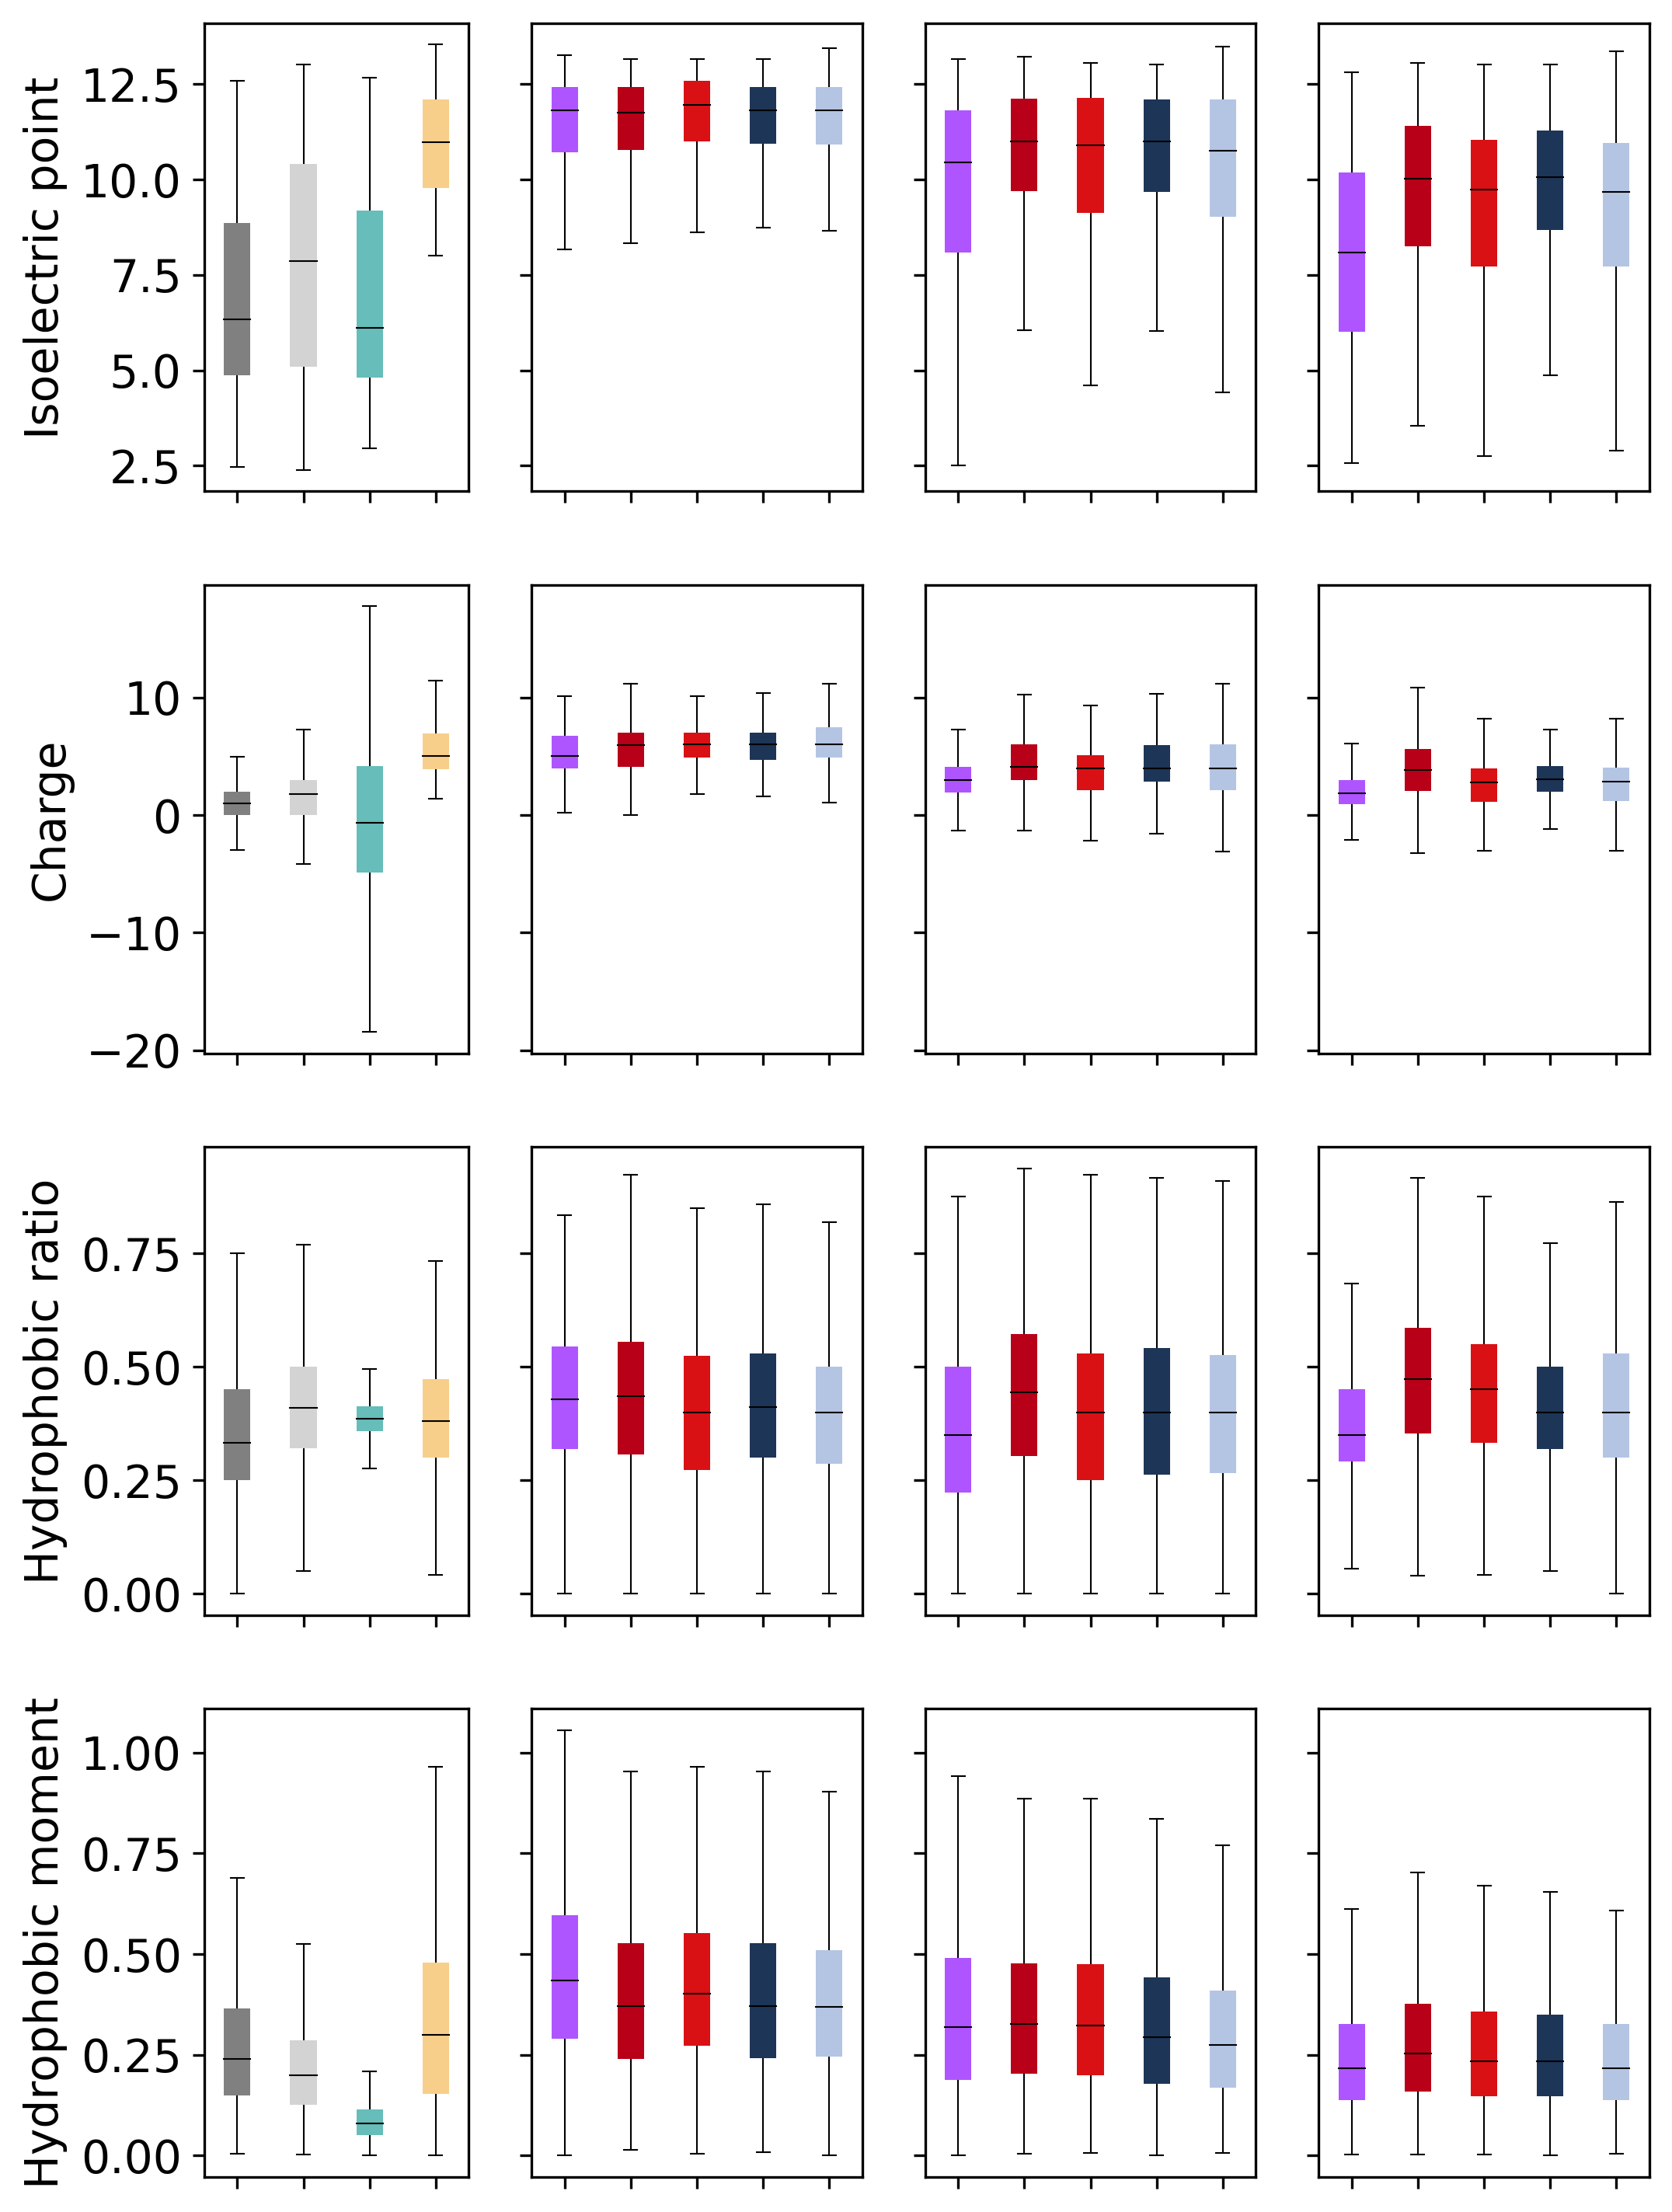

In [23]:
fig, axes = plt.subplots(
    ncols=4, 
    nrows=4,
    figsize=(8, 12),
    dpi=300,
    gridspec_kw={'width_ratios': [0.8, 1, 1, 1]},
    sharey='row'
)
pvalues_dict = {}

for prop, ax in zip(properties.keys(), axes):
    boxplots = []
    for dataset, physchem, subplot, palette in zip(datasets, datasets_df, ax, palettes):
        
        data = [physchem[physchem['dataset'] == x][prop].tolist() for x in dataset.keys()]
        parts = subplot.boxplot(
            data,
            showfliers=False,
            patch_artist=True,
            boxprops=boxprops,
            flierprops=flierprops,
            medianprops=medianprops,
            whiskerprops=whiskerprops,
            capprops=capprops,
            widths=0.4      
        )
        boxplots.append(parts)
        for patch, color in zip(parts['boxes'], palette.values()):
            patch.set_facecolor(color)     
            
        subplot.set_xticklabels([])
    ax[0].set_ylabel(properties[prop])
fig.savefig("figure/PhysicochemicalProperties.pdf", bbox_inches="tight")
# fig.subplots_adjust(hspace=0.3)
plt.show()